<a href="https://colab.research.google.com/github/sriraj0926/Music-generation/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extracting data from the files

The audio files need to be loaded in order to analyse and train the model.
The audio files are of the type ".wav".

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
## Importing standard libraries and checking for GPU connection.

import torch
import torchaudio

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import librosa
import librosa.display
print(torch.cuda.is_available())

False


In [5]:
filepath = '/content/gdrive/MyDrive/DeepLearning_Dataset'
music_paths = [ os.path.join(filepath, wavfile) for wavfile in os.listdir(filepath) if wavfile.endswith('.wav')] ### A list containing all the file paths contained in the folder needs to be generated


In [6]:
from scipy.io import wavfile

## Reading the wavefile from the filepaths
music_data = []
sample_rate = []
for file_path in music_paths:
    y, sr = librosa.load(file_path, sr=None)
    music_data.append(y[:30000000])
    sample_rate.append(sr)



##Data Analysis
Now that the data has been extracted as a list, we can now move on to the exploratory data analysis.

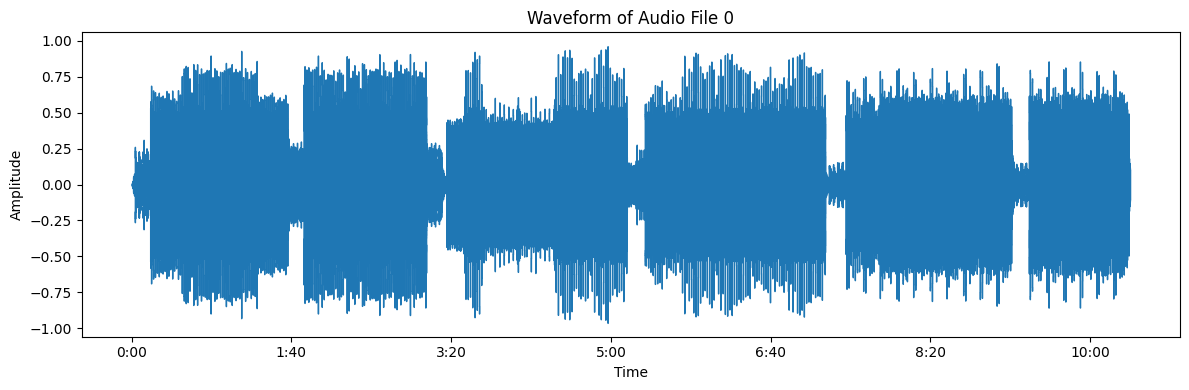

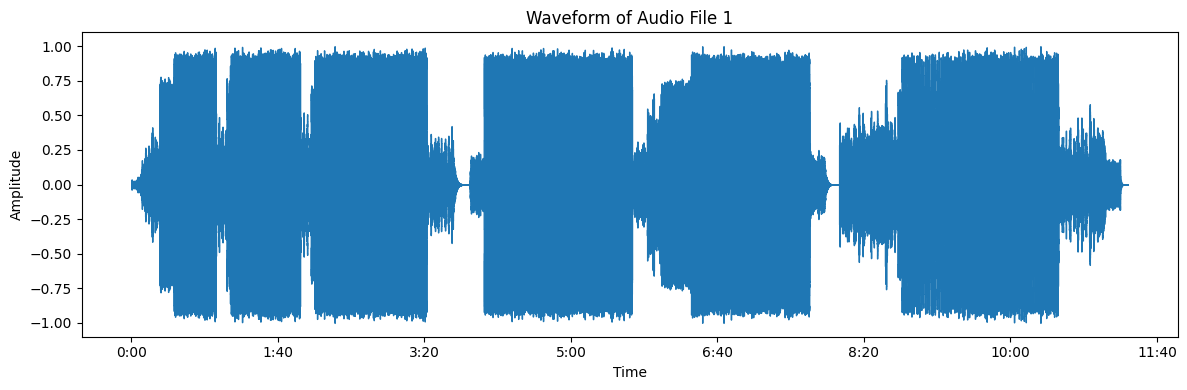

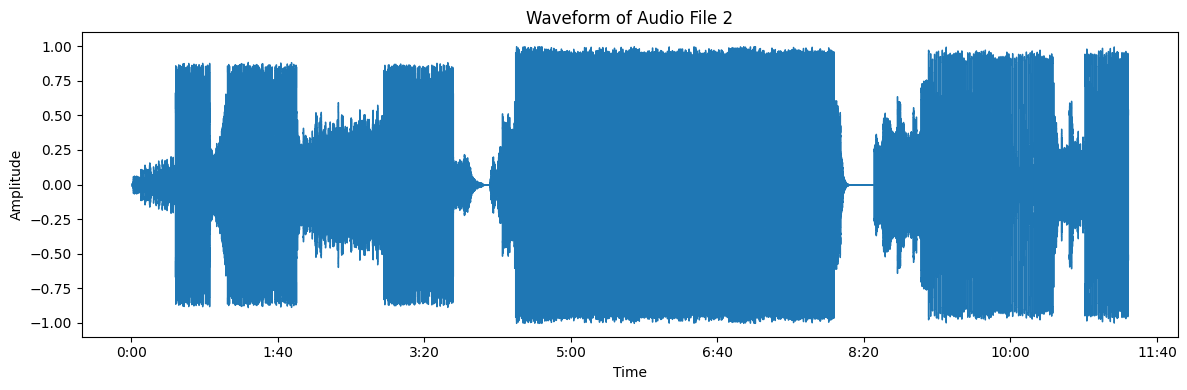

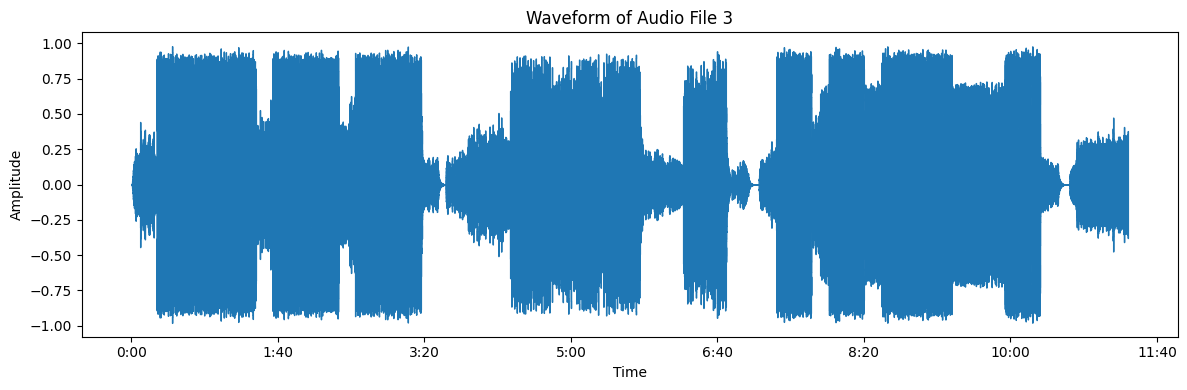

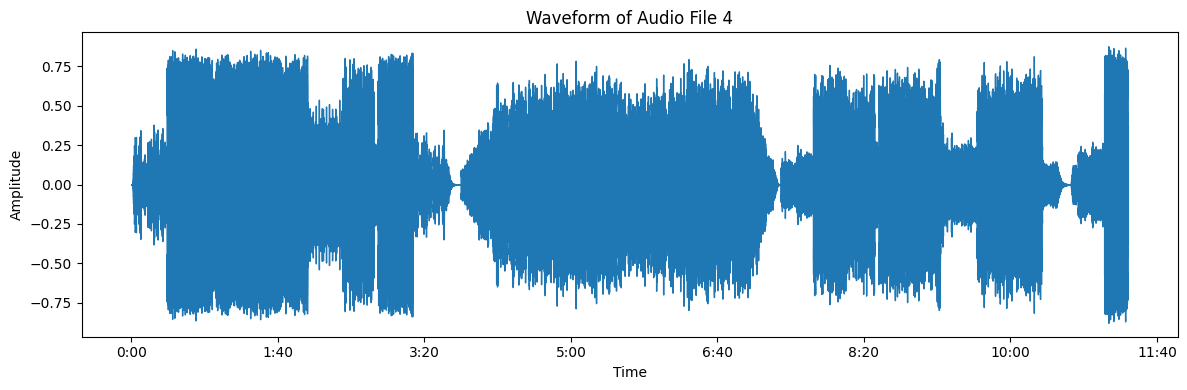

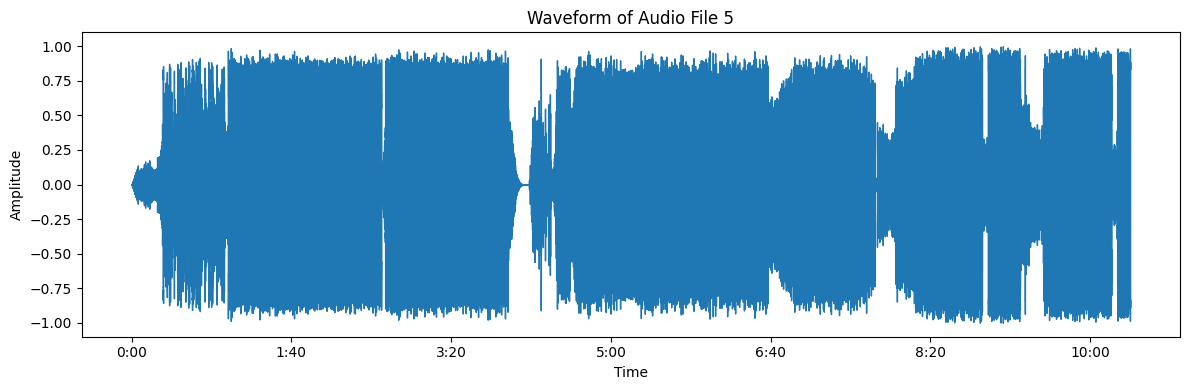

In [ ]:
for i in range(len(sample_rate)):
    # Plot the waveform
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(music_data[i], sr=sample_rate[i])
    plt.title(f"Waveform of Audio File {i}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()



In [ ]:
for i in range(len(sample_rate)):
  plt.figure(figsize=(12, 4))
  librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(music_data[i])), ref=np.max), y_axis='log', x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f"Spectrogram of Audio File {i}")
  plt.tight_layout()
  plt.show()

In [ ]:
for i in range(len(sample_rate)):
    mel_spectrogram = librosa.feature.melspectrogram(y=music_data[i], sr=sample_rate[i])
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max),
                            y_axis='mel', x_axis='time', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel-Spectrogram of Audio File {i}")
    plt.tight_layout()
    plt.show()


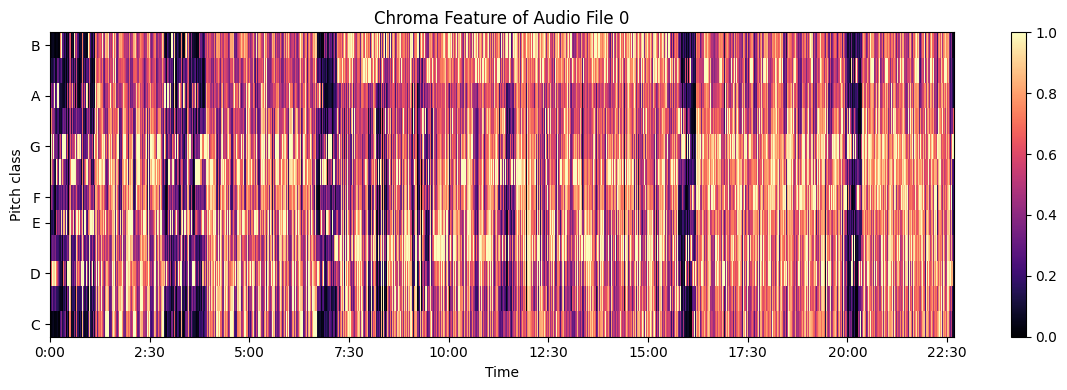

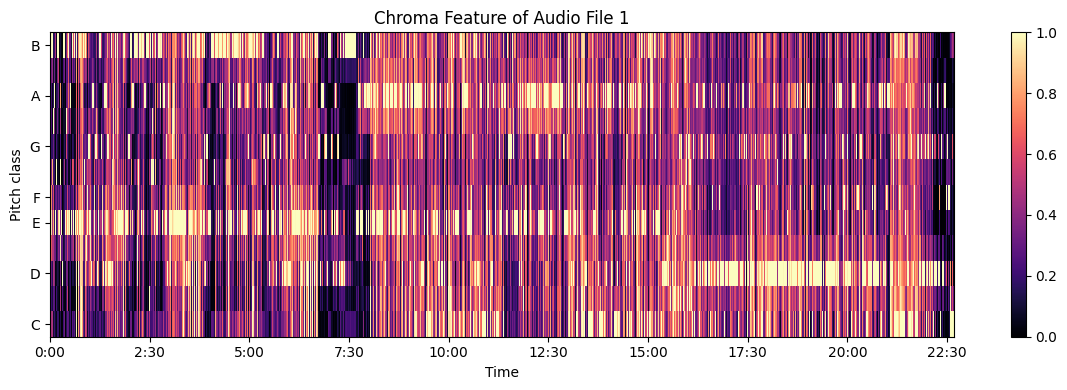

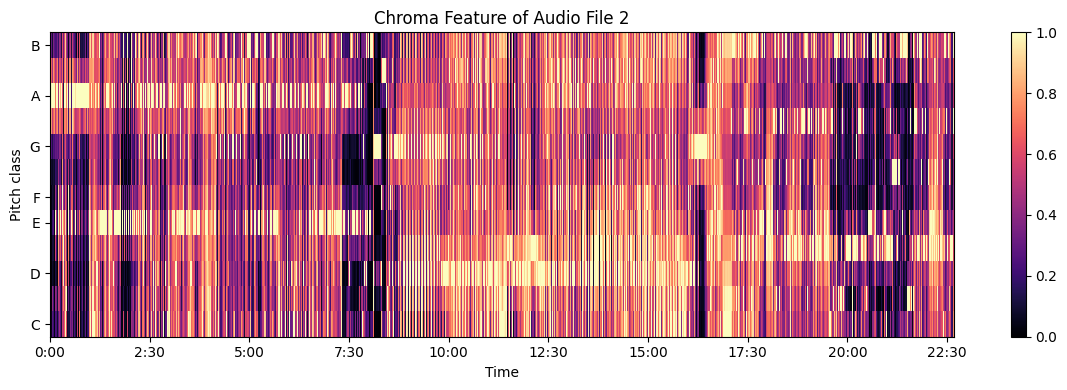

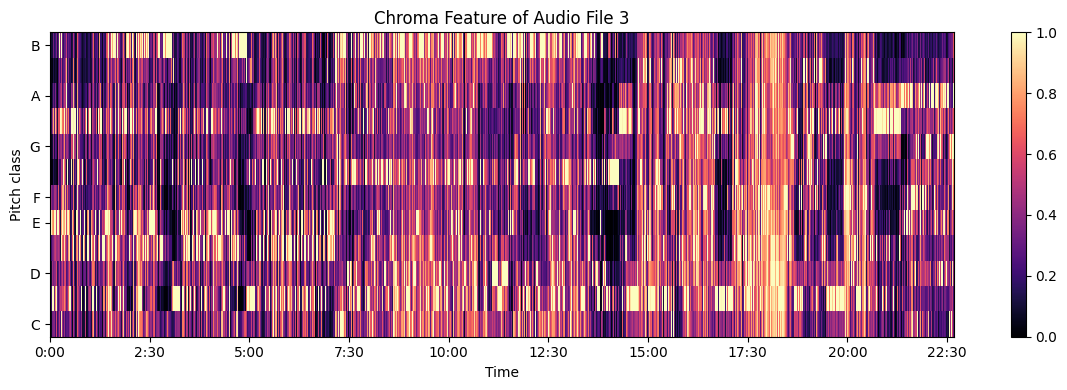

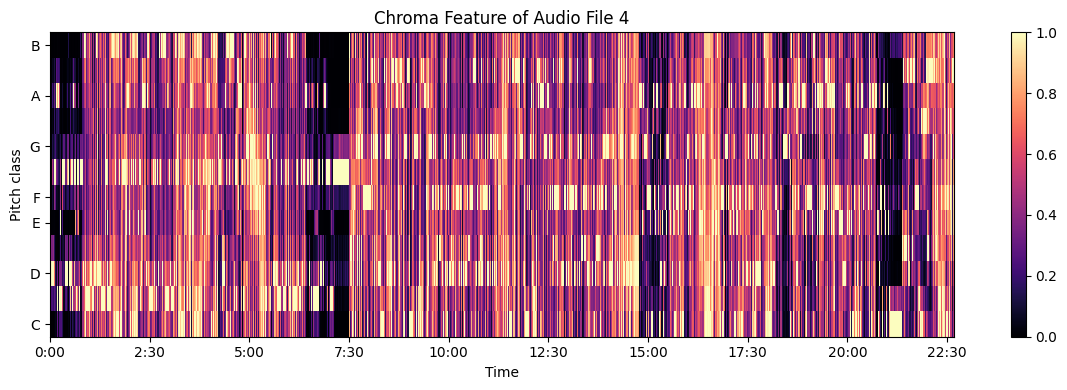

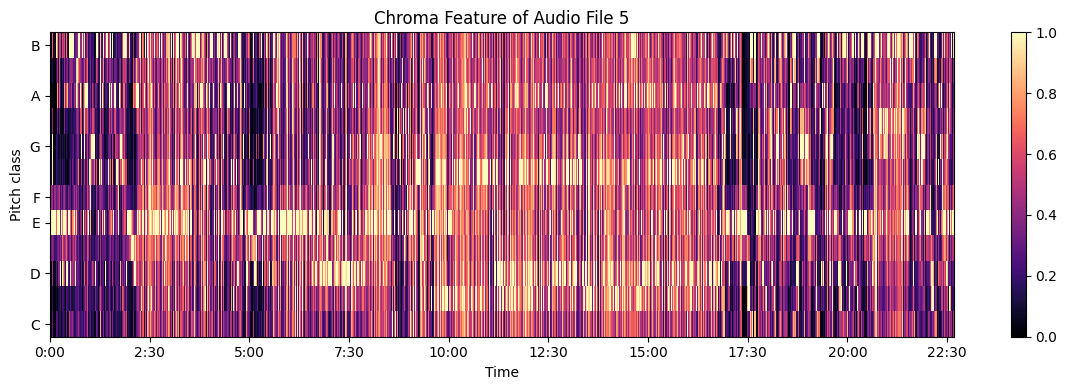

In [ ]:
for i in range(len(sample_rate)):
   # Compute and plot the chroma feature
    chroma = librosa.feature.chroma_stft(y=music_data[i], sr=sample_rate[i])
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title(f"Chroma Feature of Audio File {i}")
    plt.tight_layout()
    plt.show()

In [ ]:
from collections import Counter

In [ ]:
def toChroma(music, sr):
  chroma_map = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
  estimated_keys = []
  j = 0
  for i in range(1, len(music), int(0.05*sr)):
    chromagram = librosa.feature.chroma_stft(y = music[j:i], sr = sr)
    mean_chroma = np.mean(chromagram, axis =1)
    estimated_key_index = np.argsort(mean_chroma)
    estimated_key = [chroma_map[estimated_key_index[0]], chroma_map[estimated_key_index[1]], chroma_map[estimated_key_index[2]], chroma_map[estimated_key_index[3]]]
    estimated_keys.extend(estimated_key)
    j += int(0.05*sr)
  return estimated_keys


notes = []
for i in range(len(sample_rate)):
  estimated_keys = toChroma(music_data[i], sample_rate[i])
  notes.extend(estimated_keys)
key_count = Counter(notes)
print(key_count)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Counter({'G': 79299, 'G#': 79299, 'F#': 54319, 'F': 54319, 'A': 24980, 'A#': 24980, 'C': 125, 'C#': 125, 'D': 125, 'D#': 125})


Therefore, it can be seen that the most common notes are G, G#, F, F#, A and A#.

## Data preprocessing
Before feeding this into different neural networks, the data needs to be preprocessed.


All the files are first compiled and then split into X and y.

In [8]:
spectrogram = []

for i in range(len(sample_rate)):
  mel_spec = librosa.feature.melspectrogram(y = music_data[i], sr = sample_rate[i])
  spectrogram.extend(mel_spec)

seq_len = 100
X = []
y = []

for i in range(0, len(spectrogram) - seq_len, seq_len):
  X.append(spectrogram[i : i + seq_len])
  y.append(spectrogram[i + 1 : i + seq_len + 1])

X = np.array(X)
y = np.array(y)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, shuffle = True)

## Building the models-

4 models are used, namely -
CNN, GRU, VAE and GAN.

In [ ]:
## CNN

In [ ]:
## GRU

In [ ]:
## VAE

In [ ]:
## GAN